In [1]:
%matplotlib inline
import re
import string
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from itertools import compress


from pylab import rcParams
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords
from collections import Counter
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /srv/jupyterhub/home/bruna.scheuher/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('mbti_1.csv')

In [3]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


## Distribution of Personality Types Among Student Samples

How many samples is in the .csv file?

In [4]:
student_samples = len(df)
student_samples

8675

In [5]:
How many unique personality types is there?

Object `there` not found.


In [ ]:
How many unique personality types is there

In [6]:
def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [7]:
personality_type = len(unique(df['type']))
personality_type

16

In [8]:
dist = df['type'].value_counts()
dist

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

Text(0.5, 1.0, 'Sample distribution')

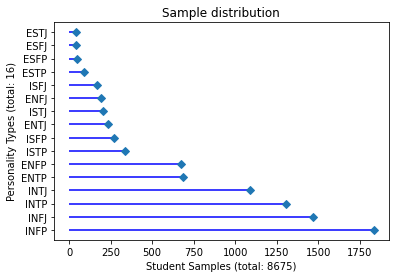

In [9]:
plt.hlines(y=list(range(16)), xmin=0, xmax=dist, color='blue')
plt.plot(dist, list(range(16)), "D")
plt.yticks(list(range(16)), dist.index)

sample_number_title = 'Student Samples (total: ' + str(student_samples) + ')'
personality_type_number_title = 'Personality Types (total: ' + str(personality_type) + ')'

plt.xlabel(sample_number_title)
plt.ylabel(personality_type_number_title) 
plt.title('Sample distribution')

## Distribution between the traits analyzed

In [10]:
df['seperated_post'] = df['posts'].apply(lambda x: x.strip().split("|||"))
df['num_post'] = df['seperated_post'].apply(lambda x: len(x))
df.head()

,type,posts,seperated_post,num_post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"['http://www.youtube.com/watch?v=qsXHcwe3krw, ...",50
1,ENTP,'I'm finding the lack of me in these posts ver...,['I'm finding the lack of me in these posts ve...,50
2,INTP,'Good one _____ https://www.youtube.com/wat...,['Good one _____ https://www.youtube.com/wa...,50
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","['Dear INTP, I enjoyed our conversation the ...",50
4,ENTJ,'You're fired.|||That's another silly misconce...,"['You're fired., That's another silly misconce...",50


In [11]:
# Before expanding the dataframe, give everyone an unique ID?
df['id'] = df.index

In [12]:
expanded_df = pd.DataFrame(df['seperated_post'].tolist(), index=df['id']).stack().reset_index(level=1, drop=True).reset_index(name='idposts')
expanded_df.head()

,id,idposts
0,0,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,0,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,0,enfp and intj moments https://www.youtube.com...
3,0,What has been the most life-changing experienc...
4,0,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...


In [13]:
expanded_df=expanded_df.join(df.set_index('id'), on='id', how = 'left')

In [14]:
expanded_df.head()

,id,idposts,type,posts,seperated_post,num_post
0,0,'http://www.youtube.com/watch?v=qsXHcwe3krw,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"['http://www.youtube.com/watch?v=qsXHcwe3krw, ...",50
1,0,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"['http://www.youtube.com/watch?v=qsXHcwe3krw, ...",50
2,0,enfp and intj moments https://www.youtube.com...,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"['http://www.youtube.com/watch?v=qsXHcwe3krw, ...",50
3,0,What has been the most life-changing experienc...,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"['http://www.youtube.com/watch?v=qsXHcwe3krw, ...",50
4,0,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"['http://www.youtube.com/watch?v=qsXHcwe3krw, ...",50


In [15]:
expanded_df=expanded_df.drop(columns=['posts','seperated_post','num_post'])

In [16]:
expanded_df.head()

,id,idposts,type
0,0,'http://www.youtube.com/watch?v=qsXHcwe3krw,INFJ
1,0,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,INFJ
2,0,enfp and intj moments https://www.youtube.com...,INFJ
3,0,What has been the most life-changing experienc...,INFJ
4,0,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,INFJ


In [18]:
# defining a function to remove hyperlinks, numbers, usernames, and punctuation
def clean_text(text):
    result = re.sub(r'http[^\s]*','link',text) # hyper links will be replaced with the word 'link'
    result = re.sub('[0-9]+','num', result).lower() # numbers will be replaced with the word 'num'
    result = re.sub('@[a-z0-9]+', 'user', result) # usernames are replaced with the word 'user'
    return re.sub('[%s]*' % string.punctuation,'',result) # punctuation are replaced with ''

In [19]:
# running the cleaning_text function on our data frame
final_df = expanded_df.copy()
final_df['idposts'] = final_df['idposts'].apply(clean_text)

In [20]:
final_df.head()

,id,idposts,type
0,0,link,INFJ
1,0,link,INFJ
2,0,enfp and intj moments link sportscenter not ...,INFJ
3,0,what has been the most lifechanging experience...,INFJ
4,0,link link on repeat for most of today,INFJ


In [21]:
df_link_examples = final_df.loc[final_df['idposts'] == 'link']
df_link_examples.head()

,id,idposts,type
0,0,link,INFJ
1,0,link,INFJ
15,0,link,INFJ
23,0,link,INFJ
26,0,link,INFJ


In [22]:
mapping = {'link': 1}
df_link_examples_rep = df_link_examples.replace({'idposts': mapping})
df_link_examples_rep.head()

,id,idposts,type
0,0,1,INFJ
1,0,1,INFJ
15,0,1,INFJ
23,0,1,INFJ
26,0,1,INFJ


In [ ]:
## We'll use plt.scatter for this

## first make a figure
## this makes a figure that is 8 units by 8 units
plt.figure(figsize = (8,8))

## plt.scatter plots RD on the x and W on the y
plt.scatter(df_link_examples_rep.type, baseball_train.W)

## Always good practice to label well when
## presenting a figure to others
## place an xlabel
plt.xlabel("Run Differential", fontsize =16)

## place a ylabel
plt.ylabel("Wins", fontsize = 16)

## type this to show the plot
plt.show()

In [23]:
dist_link = df_link_examples['type'].value_counts()/dist
dist_link

ENFJ    0.794737
ENFP    0.675556
ENTJ    0.831169
ENTP    0.613139
ESFJ    0.476190
ESFP    1.104167
ESTJ    0.794872
ESTP    0.910112
INFJ    1.208844
INFP    1.337336
INTJ    1.062328
INTP    1.302147
ISFJ    1.271084
ISFP    1.697417
ISTJ    1.102439
ISTP    1.323442
Name: type, dtype: float64

Text(0.5, 1.0, 'Likely to Post a Link Per Personality Type')

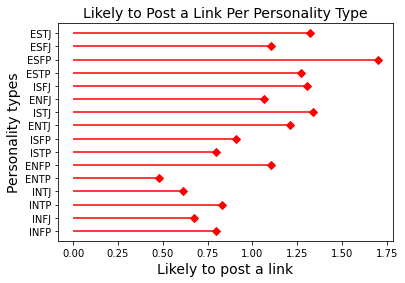

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.grid()

plt.hlines(y=list(range(16)), xmin=0, xmax=dist_link, color='red')
plt.plot(dist_link, list(range(16)), "D",  color='red')

plt.yticks(list(range(16)), dist.index)
ax.grid()
ax.set_xlabel('Likely to post a link', fontsize = 14)
ax.set_ylabel('Personality types', fontsize = 14)
ax.set_title('Likely to Post a Link Per Personality Type', fontsize = 14)

## Distribution between the personality traits analyzed words someone

In [29]:
df2 = final_df.copy()

In [30]:
df2
counts = []
typelist = []
for typeid,df_by_type in df2.groupby("type"):
    typelist.append(typeid)
    counts.append(df_by_type.shape[0])

df_stats = pd.DataFrame({"type":typelist,"counts":counts})

df_stats

,type,counts
0,ENFJ,9288
1,ENFP,32769
2,ENTJ,11273
3,ENTP,33761
4,ESFJ,2018
5,ESFP,2215
6,ESTJ,1921
7,ESTP,4337
8,INFJ,72105
9,INFP,89796


In [31]:
# load stopwords
stop_words = set(stopwords.words('english'))
for word in ['im','dont','like','think','people','really','ive','feel','much','want','say', 'always','also',
             'one','time','would','know','get','well','things','something','good','way','type','make','thats',
             'enfj','enfp','entj','entp','esfj','esfp','estj','estp','see','love','u','youre', 'even',
             'infj','infp','intj','intp','isfj','isfp','istj','istp','intjs','esfjs','enfjs','estjs']:
    stop_words.add(word)

In [32]:
## summarize the frequent words in each type
res = []
for typeid,type_df in df2.groupby("type"):
    sentence_list = type_df.idposts
    wordlist = []
    for sentence in sentence_list:
        for word in sentence.split():
            if word not in stop_words:
                wordlist.append(word)
    c = Counter(wordlist)
    print(typeid,[word for word,freq in c.most_common(3)])
#    print(typeid,c.most_common(10))
    for word,freq in c.most_common(3):
        res.append(word)

key_words_list = []

for x in res:
    if x not in key_words_list:
        key_words_list.append(x)

# key_words_list

columns_names = [col for col in key_words_list]
frames = [df2, 
          pd.DataFrame(0, index=df2.index, columns=columns_names)]
df_key_ini = pd.concat(frames,axis=1)
# df_key_ini
df_raw = df2
# df_raw

ENFJ ['num', 'link', 'someone']
ENFP ['num', 'link', 'lot']
ENTJ ['num', 'link', 'find']
ENTP ['num', 'link', 'lot']
ESFJ ['num', 'lot', 'though']
ESFP ['num', 'link', 'lot']
ESTJ ['num', 'link', 'never']
ESTP ['num', 'link', 'go']
INFJ ['num', 'link', 'life']
INFP ['num', 'link', 'lot']
INTJ ['num', 'link', 'could']
INTP ['num', 'link', 'never']
ISFJ ['num', 'link', 'lot']
ISFP ['num', 'link', 'lot']
ISTJ ['num', 'link', 'work']
ISTP ['num', 'link', 'go']


In [33]:
for word in key_words_list:
    df_raw[word] = df_raw.idposts.str.count(word)

In [34]:
#count the number of times each person mentions the keywords in their 50 social media posts
wordcount=df_raw.groupby(['id', 'type']).sum()
wordcount=wordcount.add_suffix('').reset_index()
wordcount.head(10)

,id,type,num,link,someone,lot,find,though,never,go,life,could,work
0,0,INFJ,11,24,1,0,0,1,0,5,3,2,1
1,1,ENTP,20,9,1,0,2,3,4,6,1,0,3
2,2,INTP,20,6,2,0,2,2,2,12,1,3,4
3,3,INTJ,19,2,0,3,1,5,1,6,2,2,1
4,4,ENTJ,4,6,0,0,0,3,3,14,0,0,1
5,5,INTJ,11,1,4,4,2,9,2,22,1,6,2
6,6,INFJ,23,2,3,2,0,6,3,12,1,0,0
7,7,INTJ,15,1,1,1,0,12,0,7,2,1,2
8,8,INFJ,2,23,0,2,2,3,0,10,5,2,3
9,9,INTP,8,7,1,2,2,5,4,14,2,0,1


In [35]:
wordcount_postword_someone=wordcount.groupby(['type']).sum()
wordcount_postword_someone

,id,num,link,someone,lot,find,though,never,go,life,could,work
type,,,,,,,,,,,,
ENFJ,792514,2265,540,448,492,359,695,362,1957,339,411,422
ENFP,3014151,9082,1837,1290,1864,1171,2627,1278,7156,1256,1455,1424
ENTJ,1059986,3320,669,419,493,462,748,358,2272,393,415,600
ENTP,2885655,10553,1794,1123,1621,1274,2527,1261,6989,1103,1377,1474
ESFJ,190296,612,70,89,161,103,181,69,397,69,88,71
ESFP,190912,731,145,71,102,64,148,78,384,69,80,71
ESTJ,162288,494,108,74,99,87,111,87,358,69,72,107
ESTP,351313,1243,310,165,211,128,297,158,988,161,183,204
INFJ,6344950,20041,5155,3157,3757,2922,5873,2973,15021,3251,3111,3271


In [36]:
wordcount_postword = wordcount_postword_someone["someone"]/dist 
wordcount_postword

ENFJ    2.357895
ENFP    1.911111
ENTJ    1.813853
ENTP    1.639416
ESFJ    2.119048
ESFP    1.479167
ESTJ    1.897436
ESTP    1.853933
INFJ    2.147619
INFP    1.946507
INTJ    1.765353
INTP    1.694785
ISFJ    1.843373
ISFP    1.734317
ISTJ    1.678049
ISTP    1.839763
dtype: float64

Text(0.5, 1.0, 'Word "Someone" Appearance Per Personality Type')

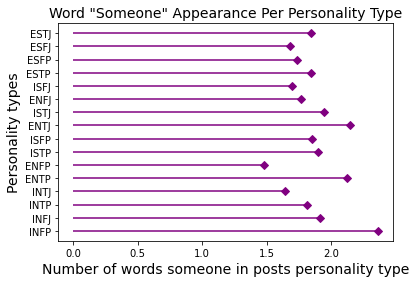

In [38]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.grid()

plt.hlines(y=list(range(16)), xmin=0, xmax=wordcount_postword, color='purple')
plt.plot(wordcount_postword, list(range(16)), "D",  color='purple')

plt.yticks(list(range(16)), dist.index)
ax.grid()
ax.set_xlabel('Number of words someone in posts personality type', fontsize = 14)
ax.set_ylabel('Personality types', fontsize = 14)
ax.set_title('Word "Someone" Appearance Per Personality Type', fontsize = 14)